Dataset address:

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

# Import packages

In [299]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_score, recall_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

# Import dataset

In [300]:
path_train = '/Users/yuwensun/Documents/编程/Kaggle/Kaggle_houseprice_prediction/train.csv'
path_test = '/Users/yuwensun/Documents/编程/Kaggle/Kaggle_houseprice_prediction/test.csv'
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

target = "SalePrice"
df_train[target] = np.log(df_train[target])

y_train = df_train[target]
df_train = df_train.iloc[:,:-1]
df_test = df_test.iloc[:,:-1]

# print(df_train.to_string())

df_full = pd.concat([df_train, df_test], keys = ['train', 'test'])

#  Id
df_full.drop("Id", axis = 1, inplace=True)

unable_deal_features = ['MiscFeature', 'MiscVal']
df_full.drop(unable_deal_features, axis = 1, inplace=True)

# print(df_full.dtypes.to_string())
print(df_full.to_string())

            MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC  Fence  MoSold  YrSold SaleType SaleCondition
train 0             60       RL         65.0     8450   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl      CollgCr 

# Exploratory Data analysis

## Handling missing values

### 1. Make some specific column feature variables fillings

In [301]:
num_feature_with_mode = ['MasVnrArea', 'BsmtFinSF2', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']
cat_feature_with_nan = ['Alley', 'FireplaceQu', 'GarageQual', 'PoolQC', 
                        'Fence', 'GarageCond', 'GarageFinish', 'GarageType', 'BsmtExposure', 
                        'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1']
disc_features = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold']

for feature in num_feature_with_mode+disc_features:
    df_full[feature].fillna(df_full[feature].mode()[0], inplace=True)

for feature in cat_feature_with_nan:
    df_full[feature].fillna("None", inplace=True)

### 2. Drop columns and rows by missing values

In [302]:
# Drop columns with over 'threshold' number of NaN values
threshold = 0.3
null_count = df_full.isnull().sum() / len(df_full)
dropped = null_count[null_count > threshold].index.to_list() # Dropped column list. Over 30% of values are NaN values.
print(f"Dropped columns with over 30% NaN values are: {dropped}")
# print("---------------------------------------------------------")
df_full.drop(dropped, axis = 1, inplace=True)

# Drop rows whose column has little missing values between (0, 0.05)
df_train = df_full.loc['train'].copy()
df_test = df_full.loc['test'].copy()
null_count = df_train.isnull().sum() / len(df_train)

columns = null_count[(null_count > 0) & (null_count < 0.03)].index.to_list()
df_train.dropna(subset = columns, axis = 0, inplace=True)
dropped_indices = df_full.loc['train'].index.difference(df_train.index).tolist()
print(f"Dropped indices are {dropped_indices}")
print(f"Columns having missing values percentage between (0, 0.03) are: {columns}")
df_full = pd.concat([df_train, df_test], keys = ['train', 'test'])
# df_full_dropped.shape

Dropped columns with over 30% NaN values are: ['SaleCondition']
Dropped indices are [234, 529, 650, 936, 973, 977, 1243, 1278, 1379]
Columns having missing values percentage between (0, 0.03) are: ['MasVnrType', 'Electrical']


### 3. Filling missing values of num (non-discrete and non_with_mode), cat

In [303]:
# Missed value columns
null_count = df_full.isnull().sum() / len(df_full)
missvalue_index = null_count[null_count != 0].index.to_list()
print(f"Missed values are {missvalue_index}")

# df_full_X_dropped[missvalue_index].dtypes
# df_full_X_dropped[missvalue_index]
missvalue_index_num = [f for f in missvalue_index if (df_full.dtypes[f] != 'object')]
missvalue_index_cat = [f for f in missvalue_index if (df_full.dtypes[f] == 'object')]
print(f"Numercial columns are going to fill missing values are: {missvalue_index_num}")
print(f"Categorical columns are going to fill missing values are: {missvalue_index_cat}")

Missed values are ['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'KitchenQual', 'Functional', 'GarageArea', 'SaleType']
Numercial columns are going to fill missing values are: ['LotFrontage', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
Categorical columns are going to fill missing values are: ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'KitchenQual', 'Functional', 'SaleType']


#### - Numeric values (non-discrete and non_with_mode)

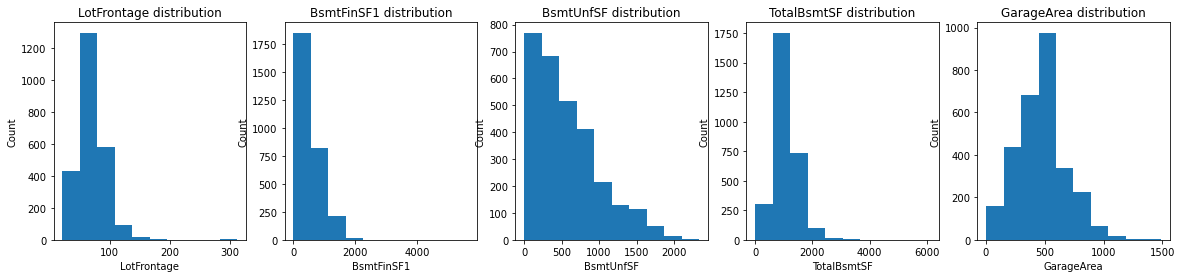

In [304]:
# Dealing with missing values of num categories
fig, ax = plt.subplots(1,len(missvalue_index_num), figsize = (4 * len(missvalue_index_num), 4))
for index in missvalue_index_num:
    i = missvalue_index_num.index(index)
    ax[i].hist(df_full.loc[(~df_full[index].isnull()), index])
    ax[i].set_title(index + ' distribution')
    ax[i].set_xlabel(index)
    ax[i].set_ylabel('Count')

## After seeing all histograms, because it has some outliers, so we'd better to use median for missing values 
for index in missvalue_index_num:
    df_full[index].fillna(df_full[index].median(skipna = True), inplace = True)

# df_train_X_dropped[missvalue_index_num].info()

#### - Categorical values

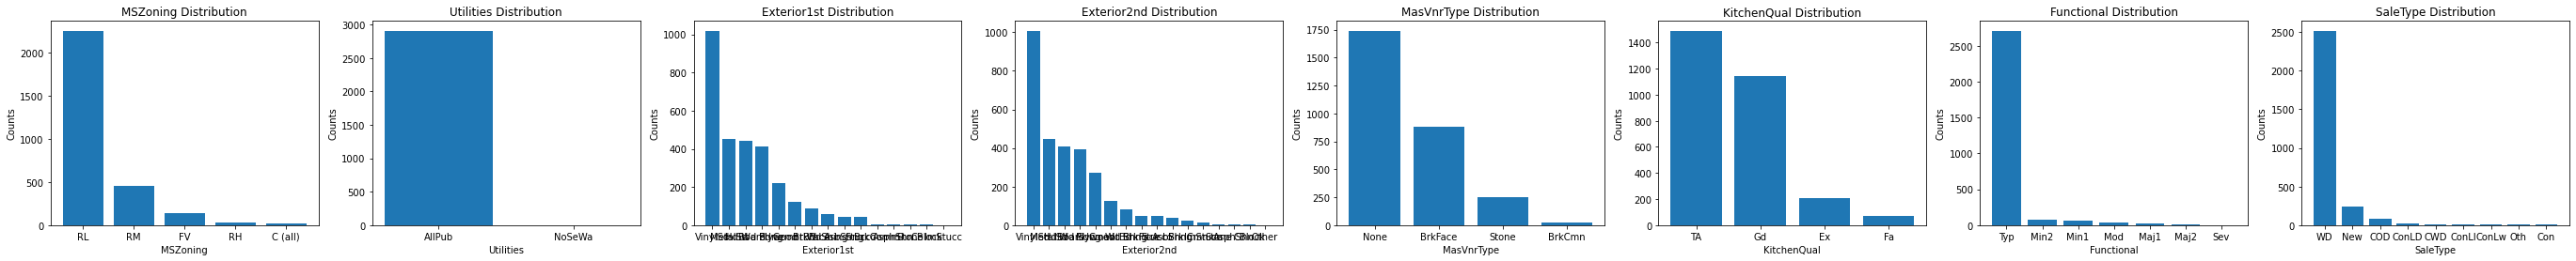

In [305]:
fix, ax = plt.subplots(1,len(missvalue_index_cat), figsize = (6 * len(missvalue_index_cat),4))

for index in missvalue_index_cat:
    i = missvalue_index_cat.index(index)

    feature_counts = df_full.loc[~df_full[index].isnull(), index].value_counts()
    features = feature_counts.index.to_list()
    counts = feature_counts.to_list()

    ax[i].bar(features, counts)
    ax[i].set_title(index + ' Distribution')
    ax[i].set_xlabel(index)
    ax[i].set_ylabel('Counts')

# filling categorical missing values
for index in missvalue_index_cat:
    df_full[index].dropna(df_full[index].mode(dropna = True)[0], inplace = True)

# df_train_dropped.isnull().sum()[df_train_dropped.isnull().sum() != 0]

In [306]:
df_full
# sum(df_full.isnull().sum())

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
train 0             60       RL         65.0     8450   Pave  None      Reg   
      1             20       RL         80.0     9600   Pave  None      Reg   
      2             60       RL         68.0    11250   Pave  None      IR1   
      3             70       RL         60.0     9550   Pave  None      IR1   
      4             60       RL         84.0    14260   Pave  None      IR1   
...                ...      ...          ...      ...    ...   ...      ...   
test  1454         160       RM         21.0     1936   Pave  None      Reg   
      1455         160       RM         21.0     1894   Pave  None      Reg   
      1456          20       RL        160.0    20000   Pave  None      Reg   
      1457          85       RL         62.0    10441   Pave  None      Reg   
      1458          60       RL         74.0     9627   Pave  None      Reg   

           LandContour Utilities LotConfig  ... OpenPorchSF EnclosedPorch  \
train 0            Lvl    AllPub    Inside  ...          61             0   
      1            Lvl    AllPub       FR2  ...           0             0   
      2            Lvl    AllPub    Inside  ...          42             0   
      3            Lvl    AllPub    Corner  ...          35           272   
      4            Lvl    AllPub       FR2  ...          84             0   
...                ...       ...       ...  ...         ...           ...   
test  1454         Lvl    AllPub    Inside  ...           0             0   
      1455         Lvl    AllPub    Inside  ...          24             0   
      1456         Lvl    AllPub    Inside  ...           0             0   
      1457         Lvl    AllPub    Inside  ...          32             0   
      1458         Lvl    AllPub    Inside  ...          48             0   

           3SsnPorch ScreenPorch PoolArea PoolQC  Fence  MoSold  YrSold  \
train 0            0           0        0   None   None       2    2008   
      1            0           0        0   None   None       5    2007   
      2            0           0        0   None   None       9    2008   
      3            0           0        0   None   None       2    2006   
      4            0           0        0   None   None      12    2008   
...              ...         ...      ...    ...    ...     ...     ...   
test  1454         0           0        0   None   None       6    2006   
      1455         0           0        0   None   None       4    2006   
      1456         0           0        0   None   None       9    2006   
      1457         0           0        0   None  MnPrv       7    2006   
      1458         0           0        0   None   None      11    2006   

            SaleType  
train 0           WD  
      1           WD  
      2           WD  
      3           WD  
      4           WD  
...              ...  
test  1454        WD  
      1455        WD  
      1456        WD  
      1457        WD  
      1458        WD  

[2910 rows x 76 columns]

# Data Preprocessing

## 1. Drop collinear columns

In [307]:
## Split into numeric and categorical data
target = 'SalePrice'
# df_full[disc_features] = df_full[disc_features].astype(str)

# Numeric features
num_features = [f for f in df_full.dtypes.index.to_list() if (df_full.dtypes[f] != 'object')]
print(f"Length: {len(num_features)}, {num_features}")

# Categorical features
cat_features = [f for f in df_full.dtypes.index.to_list() if (df_full.dtypes[f] == 'object')]
cat_features
print(f"Length: {len(cat_features)}, {cat_features}")

df_full.dtypes

Length: 35, ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold']
Length: 41, ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual

MSSubClass       int64
MSZoning        object
LotFrontage    float64
LotArea          int64
Street          object
                ...   
PoolQC          object
Fence           object
MoSold           int64
YrSold           int64
SaleType        object
Length: 76, dtype: object

In [308]:
# Drop > threshold variables
# print(df_full.dtypes)
df_train = df_full.loc['train']
corr = df_train.corr()
# sns.pairplot(df_train_dropped[num_features])
corr
drop_lst = []; threshold = 0.6
for i in range(len(corr)): # traverse rows
    for j in range(i+1, len(corr)): # traverse columns after column i
        if (corr.index.to_list()[i] not in drop_lst) & (abs(corr.iloc[i, j]) > 0.6): # after drop some column, no need to traverse its correpsonding row afterwards
            if corr.columns.to_list()[j] not in drop_lst:
                # drop_lst.append((corr.index.to_list()[i], corr.columns.to_list()[j])) # drop column list
                print((corr.index.to_list()[i], corr.columns.to_list()[j]))


drop_lst = ['GarageCars', 'GarageYrBlt', 'BsmtFullBath', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr']
# corr
df_full.drop(drop_lst, axis=1, inplace=True)
print(df_full.to_string())

('OverallQual', 'GarageCars')
('YearBuilt', 'GarageYrBlt')
('BsmtFinSF1', 'BsmtFullBath')
('TotalBsmtSF', '1stFlrSF')
('2ndFlrSF', 'GrLivArea')
('2ndFlrSF', 'HalfBath')
('2ndFlrSF', 'TotRmsAbvGrd')
('GrLivArea', 'FullBath')
('GrLivArea', 'TotRmsAbvGrd')
('BedroomAbvGr', 'TotRmsAbvGrd')
('GarageCars', 'GarageArea')
            MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  LowQualFinSF  BsmtHalfBath  FullBath  HalfBath  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType GarageFinish  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  

## 2. Encoding categorical variables & train-test split

In [309]:
num_features = [f for f in df_full.dtypes.index.to_list() if (df_full.dtypes[f] != 'object')]
print(f"Length: {len(num_features)}, {num_features}")

# Categorical features
cat_features = [f for f in df_full.dtypes.index.to_list() if (df_full.dtypes[f] == 'object')]
cat_features
print(f"Length: {len(cat_features)}, {cat_features}")

Length: 28, ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold']
Length: 41, ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType']


In [310]:
# df_train = df_full.loc['train']
# df_test = df_full.loc['test']
# print(df_train['Exterior1st'].value_counts().sort_values())
# print('-------')
# print(df_test['Exterior1st'].value_counts().sort_values())

In [311]:
# Train-test split 
X_dev = df_full.loc['train'].copy()
X_test = df_full.loc['test'].copy()

y_dev = y_train.drop(dropped_indices)

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, random_state=42)

# Encoding
for feature in cat_features:
    enc = OrdinalEncoder(categories = [X_train[feature].unique().tolist()], 
                         handle_unknown='use_encoded_value', unknown_value=-1)
    X_train[feature] = enc.fit_transform(X_train[feature].to_numpy().reshape(-1,1))
    X_val[feature] = enc.transform(X_val[feature].to_numpy().reshape(-1,1))
    X_test[feature] = enc.transform(X_test[feature].to_numpy().reshape(-1,1))

## 3. Scaling for numeric variables

In [312]:
print(sorted(disc_features))
print(sorted(num_features))

['BedroomAbvGr', 'BsmtFullBath', 'BsmtHalfBath', 'Fireplaces', 'FullBath', 'GarageCars', 'GarageYrBlt', 'HalfBath', 'KitchenAbvGr', 'MSSubClass', 'MoSold', 'OverallCond', 'OverallQual', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'YrSold']
['3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']


In [313]:
ss = StandardScaler()
# X_train[num_features] = ss.fit_transform(X_train[num_features])
# X_val[num_features] = ss.transform(X_val[num_features])
# X_test[num_features] = ss.transform(X_test[num_features])
for f in ['GarageCars', 'GarageYrBlt', 'BedroomAbvGr', 'BsmtFullBath']:
    disc_features.remove(f)

for f in disc_features:
    num_features.remove(f)

X_train[num_features] = ss.fit_transform(X_train[num_features])
X_val[num_features] = ss.transform(X_val[num_features])
X_test[num_features] = ss.transform(X_test[num_features])

In [314]:
# Hyperparameter tunning
rf = RandomForestRegressor(random_state=42)
hyper = {'n_estimators': np.arange(40, 200, 5),
         'max_depth': np.arange(5,20, 5)}

rfcv = GridSearchCV(rf, hyper, cv = 10)
rfcv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': array([ 5, 10, 15]),
                         'n_estimators': array([ 40,  45,  50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100,
       105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165,
       170, 175, 180, 185, 190, 195])})

In [315]:
rfcv.best_estimator_

RandomForestRegressor(max_depth=15, n_estimators=195, random_state=42)

# Model selection

## Random Forest

In [316]:
X_test
# test_Id = pd.read_csv(path_test)['Id'].to_list()
# len(test_Id)

MSSubClass  MSZoning  LotFrontage   LotArea  Street  Alley  LotShape  \
0             20       3.0     0.464778  0.075590     0.0    0.0       1.0   
1             20       0.0     0.509104  0.310976     0.0    0.0       0.0   
2             60       0.0     0.198818  0.272086     0.0    0.0       0.0   
3             60       0.0     0.376125 -0.070714     0.0    0.0       0.0   
4            120       0.0    -1.175308 -0.513274     0.0    0.0       0.0   
...          ...       ...          ...       ...     ...    ...       ...   
1454         160       1.0    -2.150493 -0.786392     0.0    0.0       1.0   
1455         160       1.0    -2.150493 -0.790130     0.0    0.0       1.0   
1456          20       0.0     4.010908  0.821171     0.0    0.0       1.0   
1457          85       0.0    -0.333102 -0.029510     0.0    0.0       1.0   
1458          60       0.0     0.198818 -0.101950     0.0    0.0       1.0   

      LandContour  Utilities  LotConfig  ...  OpenPorchSF  EnclosedPorch  \
0             0.0        0.0        0.0  ...    -0.716910      -0.356565   
1             0.0        0.0        2.0  ...    -0.176069      -0.356565   
2             0.0        0.0        0.0  ...    -0.206116      -0.356565   
3             0.0        0.0        0.0  ...    -0.176069      -0.356565   
4             3.0        0.0        0.0  ...     0.515006      -0.356565   
...           ...        ...        ...  ...          ...            ...   
1454          0.0        0.0        0.0  ...    -0.716910      -0.356565   
1455          0.0        0.0        0.0  ...    -0.356349      -0.356565   
1456          0.0        0.0        0.0  ...    -0.716910      -0.356565   
1457          0.0        0.0        0.0  ...    -0.236162      -0.356565   
1458          0.0        0.0        0.0  ...     0.004212      -0.356565   

      3SsnPorch  ScreenPorch  PoolArea  PoolQC  Fence  MoSold  YrSold  \
0     -0.125695     1.915666  -0.06713     0.0    1.0       6    2010   
1     -0.125695    -0.269707  -0.06713     0.0    0.0       6    2010   
2     -0.125695    -0.269707  -0.06713     0.0    1.0       3    2010   
3     -0.125695    -0.269707  -0.06713     0.0    0.0       6    2010   
4     -0.125695     2.352740  -0.06713     0.0    0.0       1    2010   
...         ...          ...       ...     ...    ...     ...     ...   
1454  -0.125695    -0.269707  -0.06713     0.0    0.0       6    2006   
1455  -0.125695    -0.269707  -0.06713     0.0    0.0       4    2006   
1456  -0.125695    -0.269707  -0.06713     0.0    0.0       9    2006   
1457  -0.125695    -0.269707  -0.06713     0.0    1.0       7    2006   
1458  -0.125695    -0.269707  -0.06713     0.0    0.0      11    2006   

      SaleType  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
...        ...  
1454       0.0  
1455       0.0  
1456       0.0  
1457       0.0  
1458       0.0  

[1459 rows x 69 columns]

In [317]:
rf = RandomForestRegressor(n_estimators=195, max_depth=15, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
# rf.score(X_val, y_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print("RMSE:", rmse)

RMSE: 0.1504210483603128


# Feature selection

/Users/yuwensun/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


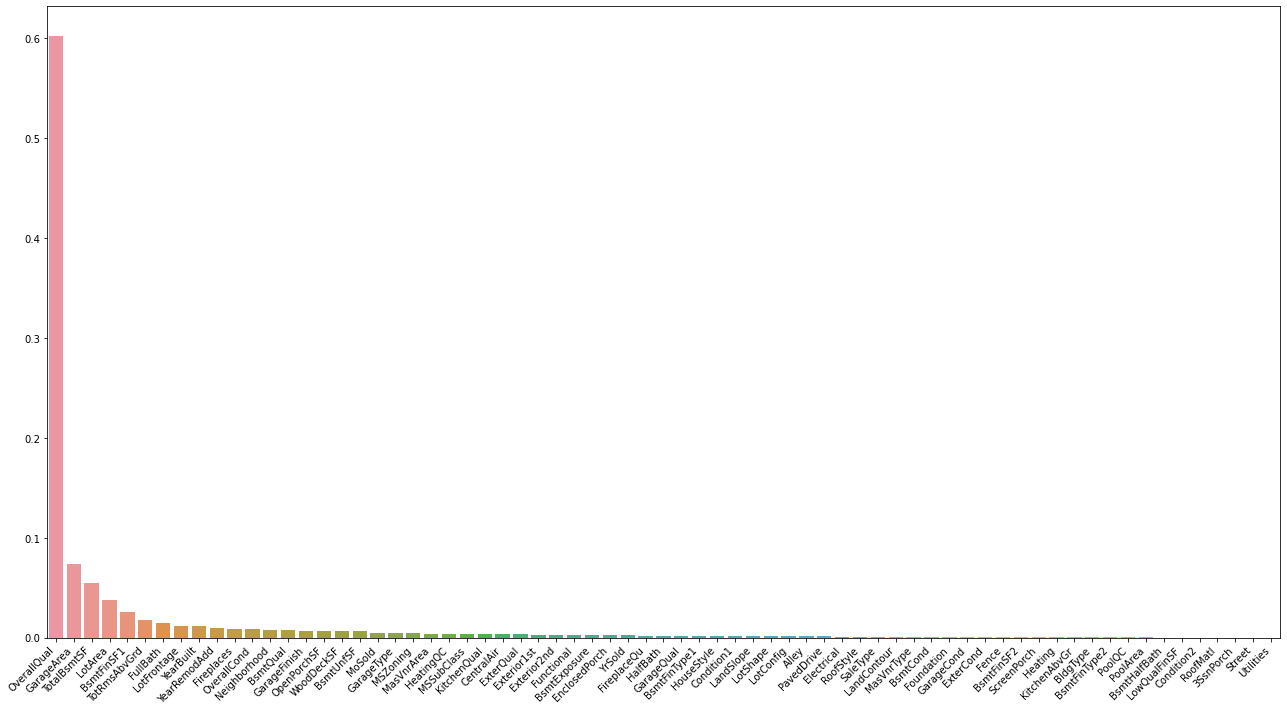

In [318]:
# Feature importance
X = X_train.columns.to_list()
importance = rf.feature_importances_

sorted_idx = importance.argsort()[::-1]
X_sorted = [X[i] for i in sorted_idx]
importance_sorted = [importance[i] for i in sorted_idx]

fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(X_sorted, importance_sorted)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


In [319]:
features_selected = X_sorted[0:20]
X_train = X_train[features_selected]
X_val = X_val[features_selected]
X_test = X_test[features_selected]

rf = RandomForestRegressor(random_state=42)
hyper = {'n_estimators': np.arange(40, 200, 5),
         'max_depth': np.arange(5,20, 5)}

rfcv = GridSearchCV(rf, hyper, cv = 10)
rfcv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': array([ 5, 10, 15]),
                         'n_estimators': array([ 40,  45,  50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100,
       105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165,
       170, 175, 180, 185, 190, 195])})

In [329]:
rfcv.best_estimator_

RandomForestRegressor(max_depth=15, n_estimators=195, random_state=42)

In [330]:
rf = RandomForestRegressor(n_estimators=195, max_depth=15, random_state=42)
rf.fit(X_train, y_train)
X_val = X_val[features_selected]
y_pred = rf.predict(X_val)
# rf.score(X_val, y_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print("RMSE:", rmse)

RMSE: 0.1528354765615983


# Submission of output

## Output the results

In [327]:
# Prediction
path_test = '/Users/yuwensun/Documents/编程/Kaggle/Kaggle_houseprice_prediction/test.csv'
test_Id = pd.read_csv(path_test)['Id'].to_list()
y_test = np.exp(rf.predict(X_test))

output = pd.DataFrame({'Id': test_Id, 'SalePrice': y_test})
output

Id      SalePrice
0     1461  138666.219304
1     1462  154224.031676
2     1463  170456.723000
3     1464  182449.736242
4     1465  191983.069459
...    ...            ...
1454  2915   83827.365495
1455  2916   88838.723253
1456  2917  176299.017268
1457  2918  123861.595732
1458  2919  242063.653588

[1459 rows x 2 columns]

## Save submission

In [328]:
save_path = '/Users/yuwensun/Documents/编程/Kaggle/Kaggle_houseprice_prediction/submission.csv'
output.to_csv(save_path, index=False)